In [1]:
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, MultiPoint
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import json

# Configurações de visualização
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (14, 10)

# Conexão com o banco de dados (use suas credenciais)
DB_USER = "myuser"
DB_PASS = "mypassword"
DB_HOST = "localhost" 
DB_PORT = "5432"
DB_NAME = "bus_predictions"
DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DATABASE_URL)

print("Ambiente do Notebook pronto.")

Ambiente do Notebook pronto.


In [2]:
linha_alvo = 371
data_inicio = '2024-04-25'
data_fim = '2024-04-28'
sql_query = f"""
    SELECT * FROM gps_data 
    WHERE linha = '{linha_alvo}' 
    AND datahoraservidor >= '{data_inicio}' 
    AND datahoraservidor < '{data_fim}'
"""
try:
    gdf = gpd.read_postgis(sql_query, engine, geom_col='geom')
    print(f"{len(gdf)} registros carregados do banco de dados.")
except Exception as e:
    print(f"Erro ao conectar ao banco de dados: {e}")
    # Criando um DataFrame de exemplo para continuar a execução sem DB
    print("Criando um DataFrame de exemplo para demonstração.")
    data = {'ordem': ['A001']*100 + ['A002']*100,
            'datahoraservidor': pd.to_datetime(pd.date_range('2024-04-25 08:00', periods=200, freq='T')),
            'velocidade': np.random.randint(0, 60, 200),
            'latitude': np.linspace(-22.90, -22.95, 100).tolist() + np.linspace(-22.95, -22.90, 100).tolist(),
            'longitude': np.linspace(-43.20, -43.25, 100).tolist() + np.linspace(-43.25, -43.20, 100).tolist()
           }
    df_exemplo = pd.DataFrame(data)
    gdf = gpd.GeoDataFrame(df_exemplo, geometry=gpd.points_from_xy(df_exemplo.longitude, df_exemplo.latitude))
    gdf['geom'] = gdf['geometry'] # Renomeando para corresponder ao script

250120 registros carregados do banco de dados.


## Limpeza e Validação dos Dados Carregados

In [3]:
# 1. Garante que os dados estão no formato correto e ordena
gdf['datahoraservidor'] = pd.to_datetime(gdf['datahoraservidor'])
gdf.sort_values(by=['ordem', 'datahoraservidor'], inplace=True)

# 2. Filtra pelo horário de operação (08:00 até 22:59)
gdf['hora'] = gdf['datahoraservidor'].dt.hour
gdf_operacao = gdf[gdf['hora'].between(8, 22)].copy()

# 3. Remove velocidades irreais e duplicatas
gdf_operacao = gdf_operacao[gdf_operacao['velocidade'] <= 120]
gdf_operacao.drop_duplicates(inplace=True)

print(f"Após a limpeza, restaram {len(gdf_operacao)} registros para a análise.")
display(gdf_operacao.head())

Após a limpeza, restaram 212713 registros para a análise.


,id,ordem,latitude,longitude,datahora,velocidade,linha,datahoraenvio,datahoraservidor,geom,hora
8720,1577204,B51539,-22.87856,-43.35818,2024-04-25 09:09:35,22,371,2024-04-25 09:09:48,2024-04-25 09:10:05,POINT (-43.35818 -22.87856),9
8878,1580197,B51539,-22.87975,-43.35567,2024-04-25 09:10:05,40,371,2024-04-25 09:10:10,2024-04-25 09:10:35,POINT (-43.35567 -22.87975),9
9017,1584723,B51539,-22.88116,-43.35225,2024-04-25 09:10:35,42,371,2024-04-25 09:10:41,2024-04-25 09:11:06,POINT (-43.35225 -22.88116),9
9053,1589265,B51539,-22.88228,-43.34925,2024-04-25 09:11:05,31,371,2024-04-25 09:11:13,2024-04-25 09:11:37,POINT (-43.34925 -22.88228),9
8759,1593818,B51539,-22.88260,-43.34834,2024-04-25 09:11:35,9,371,2024-04-25 09:11:45,2024-04-25 09:12:07,POINT (-43.34834 -22.8826),9


## Identificar Pontos do Ônibus -> Separar Ida e Volta -> Construir Caminhos

In [4]:
# --- ETAPA A: Identificar Pontos Terminais ---
print("Iniciando a identificação de terminais...")
paradas = gdf_operacao[gdf_operacao['velocidade'] == 0].copy()
paradas['tempo_diff_min'] = paradas.groupby('ordem')['datahoraservidor'].diff().dt.total_seconds() / 60
paradas_terminais = paradas[paradas['tempo_diff_min'].between(10, 30)]
print(f"Encontradas {len(paradas_terminais)} paradas longas (potenciais pontos terminais).")

# --- ETAPA B: Seleção Robusta dos 2 Terminais Principais ---
terminal_A, terminal_B = None, None
if len(paradas_terminais) >= 2:
    # Usando DBSCAN para agrupar pontos de parada geograficamente próximos
    clustering = DBSCAN(eps=0.001, min_samples=2).fit(paradas_terminais[['latitude', 'longitude']])
    paradas_terminais['terminal_cluster'] = clustering.labels_
    
    # Calcula o centroide de cada cluster de terminal encontrado
    terminais_encontrados = {
        label: MultiPoint(paradas_terminais[paradas_terminais['terminal_cluster'] == label].geometry.tolist()).centroid
        for label in paradas_terminais['terminal_cluster'].unique() if label != -1
    }
    print(f"DBSCAN encontrou {len(terminais_encontrados)} clusters de terminais.")
    
    # Seleciona os dois terminais principais
    if len(terminais_encontrados) >= 2:
        if len(terminais_encontrados) == 2:
            terminal_A, terminal_B = list(terminais_encontrados.values())
        else: # Se houver mais de 2 clusters, escolhe o par mais distante entre si
            pontos_terminais = list(terminais_encontrados.values())
            max_dist, melhor_par = 0, (None, None)
            for p1, p2 in combinations(pontos_terminais, 2):
                dist = p1.distance(p2)
                if dist > max_dist:
                    max_dist, melhor_par = dist, (p1, p2)
            terminal_A, terminal_B = melhor_par
        print("Terminais A e B definidos com sucesso.")

if not (terminal_A and terminal_B):
    print("\nAVISO: Não foi possível definir os dois terminais principais. A criação da rota pode falhar ou ser imprecisa.")

Iniciando a identificação de terminais...
Encontradas 396 paradas longas (potenciais pontos terminais).
DBSCAN encontrou 45 clusters de terminais.
Terminais A e B definidos com sucesso.


c:\Users\gupes\REPOS\datamining\Data-Mining\datamining\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### PLOT 1: Visualização dos Clusters de Terminais

Este gráfico ajuda a validar se a identificação dos terminais foi bem-sucedida.

* **Pontos de GPS (cinza):** Todos os registros de localização como plano de fundo.
* **Paradas Longas (colorido):** Pontos onde o ônibus ficou parado por um tempo significativo, coloridos pelo cluster ao qual pertencem (pontos roxos são ruído/outliers).
* **Centroides dos Terminais (vermelho):** O centro geográfico de cada cluster de terminal encontrado pelo DBSCAN.

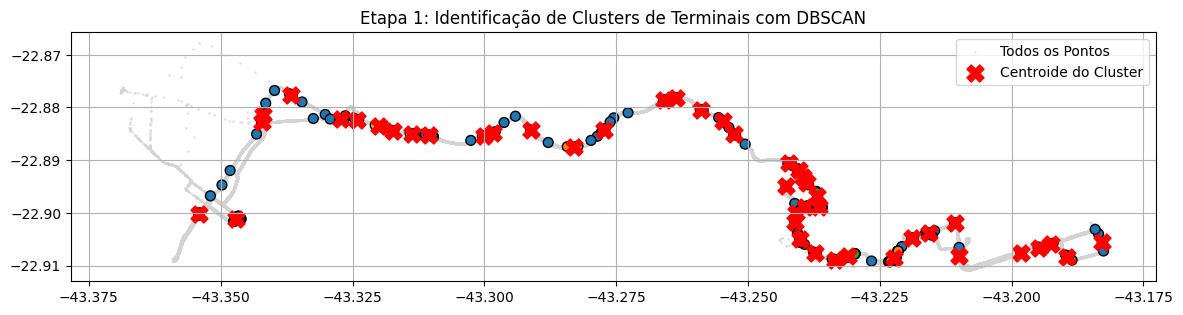

In [5]:
# --- Código de Plotagem para a Etapa 1 ---
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plota todos os pontos de operação como fundo
gdf_operacao.plot(ax=ax, color='lightgray', markersize=1, alpha=0.5, label='Todos os Pontos')

# Plota as paradas longas, coloridas por cluster do DBSCAN
if 'terminal_cluster' in paradas_terminais.columns and not paradas_terminais.empty:
    paradas_terminais.plot(
        ax=ax, 
        column='terminal_cluster', 
        categorical=True, 
        markersize=50, 
        edgecolor='black',
        legend=True,
        legend_kwds={'title': "Cluster de Terminal (DBSCAN)"}
    )

# Plota os centroides dos clusters encontrados
if 'terminais_encontrados' in locals() and terminais_encontrados:
    terminais_geo = gpd.GeoSeries(terminais_encontrados)
    terminais_geo.plot(ax=ax, color='red', marker='X', markersize=150, label='Centroide do Cluster')

plt.title("Etapa 1: Identificação de Clusters de Terminais com DBSCAN")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# --- ETAPA C: Separar os Sentidos (Ida e Volta) ---
trajetos_finais = {}
gdf_operacao['sentido'] = np.nan # Inicializa a coluna

if terminal_A and terminal_B:
    print("\nIniciando a separação de sentidos...")
    # Seleciona apenas os pontos que não são paradas terminais para clusterizar
    pontos_em_movimento_idx = gdf_operacao.index.difference(paradas_terminais.index)
    pontos_em_movimento = gdf_operacao.loc[pontos_em_movimento_idx].copy()

    if len(pontos_em_movimento) > 2:
        # Usando KMeans para dividir os pontos em dois grupos (ida e volta)
        kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(pontos_em_movimento[['latitude', 'longitude']])
        gdf_operacao.loc[pontos_em_movimento.index, 'sentido'] = labels
        print("Coluna 'sentido' criada com sucesso.")
        print(gdf_operacao['sentido'].value_counts(dropna=False))



Iniciando a separação de sentidos...
Coluna 'sentido' criada com sucesso.
sentido
1.0    112875
0.0     99442
NaN       396
Name: count, dtype: int64


### PLOT 2: Visualização da Separação de Sentidos (Ida/Volta)

Este gráfico é crucial para verificar se o algoritmo `KMeans` conseguiu separar corretamente as duas direções da linha de ônibus.

* **Pontos por Sentido (colorido):** Cada ponto de GPS é colorido de acordo com o sentido atribuído (Sentido 0 ou Sentido 1), mostrando a separação geográfica das rotas.
* **Terminais (dourado):** Os terminais A e B plotados como estrelas para dar contexto geográfico à separação.

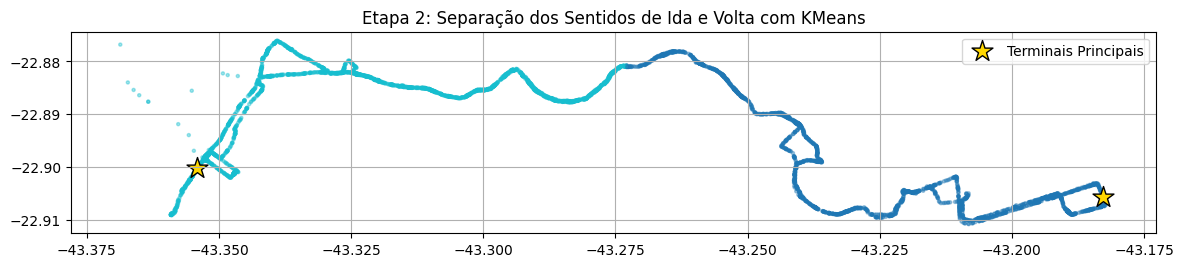

In [7]:
# --- Código de Plotagem para a Etapa 2 ---
if terminal_A and terminal_B:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Plota uma amostra dos pontos, coloridos pela coluna 'sentido'
    if not gdf_operacao[gdf_operacao['sentido'].notna()].empty:
        amostra_sentido = gdf_operacao.dropna(subset=['sentido']).sample(min(5000, len(gdf_operacao.dropna(subset=['sentido']))))
        amostra_sentido.plot(
            ax=ax, 
            column='sentido', 
            categorical=True, 
            markersize=5, 
            alpha=0.4, 
            legend=True,
            legend_kwds={'title': "Sentido (KMeans)"}
        )

    # Plota os terminais A e B para referência
    gpd.GeoSeries([terminal_A, terminal_B]).plot(ax=ax, color='gold', marker='*', markersize=250, edgecolor='black', label='Terminais Principais')
    
    plt.title("Etapa 2: Separação dos Sentidos de Ida e Volta com KMeans")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Gráfico de sentidos não gerado pois os terminais A e B não foram definidos.")

In [8]:
# --- ETAPA D: Construir os Caminhos Canônicos ---
if terminal_A and terminal_B:
    for sentido_id in gdf_operacao['sentido'].dropna().unique():
        print(f"\nConstruindo trajeto para o Sentido: {int(sentido_id)}...")
        pontos_sentido = gdf_operacao[gdf_operacao['sentido'] == sentido_id].copy()
        if len(pontos_sentido) < 2: continue
        
        # Determina o terminal de partida para este sentido
        dist_media_A = pontos_sentido.head(10).geometry.distance(terminal_A).mean()
        dist_media_B = pontos_sentido.head(10).geometry.distance(terminal_B).mean()
        terminal_partida = terminal_A if dist_media_A < dist_media_B else terminal_B
        
        # Ordena os pontos pela distância ao terminal de partida
        pontos_sentido['distancia_partida'] = pontos_sentido.geometry.distance(terminal_partida)
        pontos_ordenados = pontos_sentido.sort_values('distancia_partida')
        
        # Cria uma linha a partir dos pontos ordenados e a simplifica
        linha_ordenada = LineString(pontos_ordenados.geometry.tolist())
        trajeto_simplificado = linha_ordenada.simplify(tolerance=0.0001, preserve_topology=True)
        trajetos_finais[sentido_id] = trajeto_simplificado
        print(f"  - Trajeto para o sentido {int(sentido_id)} criado com sucesso.")


Construindo trajeto para o Sentido: 1...


C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\3994192357.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_media_A = pontos_sentido.head(10).geometry.distance(terminal_A).mean()
C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\3994192357.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_media_B = pontos_sentido.head(10).geometry.distance(terminal_B).mean()
C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\3994192357.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pontos_sentido['distancia_partida'] = pontos_sentido.geometry.distance(terminal_part

  - Trajeto para o sentido 1 criado com sucesso.

Construindo trajeto para o Sentido: 0...


C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\3994192357.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_media_A = pontos_sentido.head(10).geometry.distance(terminal_A).mean()
C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\3994192357.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_media_B = pontos_sentido.head(10).geometry.distance(terminal_B).mean()
C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\3994192357.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pontos_sentido['distancia_partida'] = pontos_sentido.geometry.distance(terminal_part

  - Trajeto para o sentido 0 criado com sucesso.


### Etapa Adicional: Remoção de Outliers Espaciais

Para garantir que estamos trabalhando apenas com dados relevantes, removemos os pontos de GPS que estão muito distantes dos trajetos canônicos que acabamos de criar. Isso elimina ruídos e dados incorretos.

In [9]:
# --- ETAPA DE REMOÇÃO DE OUTLIERS ESPACIAIS ---
print("\nIniciando a remoção de outliers espaciais...")

if trajetos_finais:
    # Define uma distância máxima em graus decimais (ajuste conforme necessário)
    # 0.0005 graus é aproximadamente 55 metros. Pode ajustar este valor.
    max_distancia_permitida = 0.0005

    def distancia_do_ponto_ao_trajeto(row):
        trajeto = trajetos_finais.get(row['sentido'])
        if trajeto:
            return row['geom'].distance(trajeto)
        return np.inf # Retorna infinito se não houver trajeto

    # Calcula a distância de cada ponto ao seu trajeto canônico
    gdf_operacao['distancia_ao_trajeto'] = gdf_operacao.apply(distancia_do_ponto_ao_trajeto, axis=1)

    # Filtra os pontos que estão dentro da distância permitida
    total_antes = len(gdf_operacao)
    gdf_operacao_sem_outliers = gdf_operacao[gdf_operacao['distancia_ao_trajeto'] <= max_distancia_permitida].copy()
    total_depois = len(gdf_operacao_sem_outliers)
    
    # Remove a coluna auxiliar
    gdf_operacao_sem_outliers.drop(columns=['distancia_ao_trajeto'], inplace=True)
    gdf_operacao.drop(columns=['distancia_ao_trajeto'], inplace=True)
    
    print(f"Remoção de outliers concluída.")
    print(f"Registros antes: {total_antes}")
    print(f"Registros depois: {total_depois}")
    print(f"Registros removidos: {total_antes - total_depois}")
else:
    print("AVISO: Remoção de outliers não executada pois os trajetos canônicos não foram criados.")
    gdf_operacao_sem_outliers = gdf_operacao.copy() # Mantém o dataframe original se a etapa falhar


Iniciando a remoção de outliers espaciais...
Remoção de outliers concluída.
Registros antes: 212713
Registros depois: 212317
Registros removidos: 396


### PLOT 3: Resultado Final - Caminhos Canônicos (Após Limpeza de Outliers)

Esta é a visualização final que consolida todos os resultados, agora usando os dados **sem outliers**:

* **Pontos por Sentido (colorido):** Uma amostra dos pontos de GPS limpos.
* **Terminais (dourado):** Os pontos finais A e B da rota.
* **Caminho Canônico (preto, tracejado):** A rota de ida e volta final.

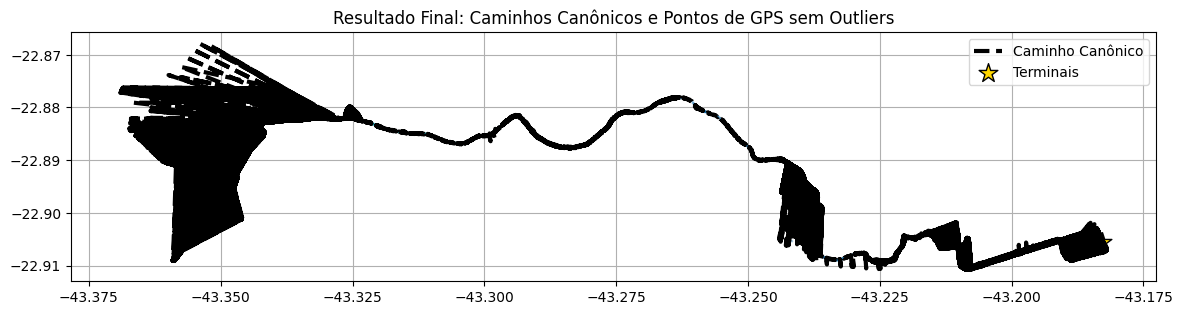

In [10]:
# --- ETAPA E: Visualização Final (COM DADOS LIMPOS) ---
if terminal_A and terminal_B and trajetos_finais:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Plota amostra de pontos de operação por sentido (AGORA USANDO O DATAFRAME LIMPO)
    if not gdf_operacao_sem_outliers[gdf_operacao_sem_outliers['sentido'].notna()].empty:
        amostra = gdf_operacao_sem_outliers.dropna(subset=['sentido']).sample(min(5000, len(gdf_operacao_sem_outliers.dropna(subset=['sentido']))))
        amostra.plot(ax=ax, column='sentido', categorical=True, markersize=1, alpha=0.3, legend=True)
    
    # Plota os caminhos canônicos
    if trajetos_finais:
        gpd.GeoSeries(trajetos_finais).plot(ax=ax, color='black', linewidth=3, linestyle='--', label='Caminho Canônico')
    
    # Plota os terminais
    gpd.GeoSeries([terminal_A, terminal_B]).plot(ax=ax, color='gold', marker='*', markersize=200, edgecolor='black', label='Terminais')
    
    plt.title("Resultado Final: Caminhos Canônicos e Pontos de GPS sem Outliers")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Gráfico final não gerado pois os terminais ou trajetos não foram definidos.")

## Feature Engineering: Criação de Variáveis para o Modelo de Machine Learning

### Calcular Distância ao Longo do Trajeto

In [11]:
def calcular_distancia_no_trajeto(row, trajetos_dict):
    ponto = row['geom']
    sentido = row['sentido']
    trajeto = trajetos_dict.get(sentido)
    
    if trajeto:
        # .project() retorna a distância do início da linha até o ponto mais próximo na linha
        return trajeto.project(ponto)
    
    return None

# Aplica a função para criar a nova coluna 'distancia_trajeto' USANDO OS DADOS LIMPOS
gdf_com_sentido = gdf_operacao_sem_outliers.dropna(subset=['sentido']).copy()

if not gdf_com_sentido.empty and trajetos_finais:
    gdf_com_sentido['distancia_trajeto'] = gdf_com_sentido.apply(
        lambda row: calcular_distancia_no_trajeto(row, trajetos_finais),
        axis=1
    )
    print("Coluna 'distancia_trajeto' criada com sucesso.")
    display(gdf_com_sentido[['ordem', 'datahoraservidor', 'sentido', 'distancia_trajeto']].head())
else:
    print("Não foi possível calcular a distância do trajeto.")

Coluna 'distancia_trajeto' criada com sucesso.


,ordem,datahoraservidor,sentido,distancia_trajeto
8720,B51539,2024-04-25 09:10:05,1.0,93.307350
8878,B51539,2024-04-25 09:10:35,1.0,92.037659
9017,B51539,2024-04-25 09:11:06,1.0,91.172492
9053,B51539,2024-04-25 09:11:37,1.0,90.782693
8759,B51539,2024-04-25 09:12:07,1.0,90.710559


### Features de Tempo

In [12]:
# 1. Hora do dia (0-23)
gdf_com_sentido['hora_do_dia'] = gdf_com_sentido['datahoraservidor'].dt.hour

# 2. Dia da semana (Seg=0, Dom=6)
gdf_com_sentido['dia_da_semana'] = gdf_com_sentido['datahoraservidor'].dt.dayofweek

# 3. Minuto do dia (0-1439)
gdf_com_sentido['minuto_do_dia'] = gdf_com_sentido['datahoraservidor'].dt.hour * 60 + gdf_com_sentido['datahoraservidor'].dt.minute

# 4. Fim de semana (Binário)
gdf_com_sentido['fim_de_semana'] = (gdf_com_sentido['dia_da_semana'] >= 5).astype(int)

print("Features de tempo criadas com sucesso:")
display(
    gdf_com_sentido[[
        'datahoraservidor',
        'hora_do_dia',
        'minuto_do_dia',
        'dia_da_semana',
        'fim_de_semana'
    ]].head()
)

Features de tempo criadas com sucesso:


,datahoraservidor,hora_do_dia,minuto_do_dia,dia_da_semana,fim_de_semana
8720,2024-04-25 09:10:05,9,550,3,0
8878,2024-04-25 09:10:35,9,550,3,0
9017,2024-04-25 09:11:06,9,551,3,0
9053,2024-04-25 09:11:37,9,551,3,0
8759,2024-04-25 09:12:07,9,552,3,0


### Features de Velocidade e Aceleração

In [13]:
# Ordena os dados para cálculos de janela móvel
gdf_com_sentido_sorted = gdf_com_sentido.sort_values(by=['ordem', 'datahoraservidor'])

# --- Velocidade Média Recente ---
rolling_mean = gdf_com_sentido_sorted.groupby('ordem')['velocidade'].rolling(window=5, min_periods=1).mean()
gdf_com_sentido['velocidade_recente_media'] = rolling_mean.reset_index(level=0, drop=True)
gdf_com_sentido['velocidade_recente_media'].fillna(method='ffill', inplace=True)
gdf_com_sentido['velocidade_recente_media'].fillna(0, inplace=True)

# --- Aceleração ---
gdf_com_sentido['aceleracao'] = gdf_com_sentido_sorted.groupby('ordem')['velocidade'].diff().fillna(0)

# --- Desvio Padrão da Velocidade Recente ---
rolling_std = gdf_com_sentido_sorted.groupby('ordem')['velocidade'].rolling(window=5, min_periods=1).std()
gdf_com_sentido['velocidade_std_recente'] = rolling_std.reset_index(level=0, drop=True).fillna(0)

print("Features de velocidade, aceleração e desvio padrão criadas.")
display(
    gdf_com_sentido[[
        'ordem',
        'datahoraservidor',
        'velocidade',
        'velocidade_recente_media',
        'aceleracao',
        'velocidade_std_recente'
    ]].head(10)
)

Features de velocidade, aceleração e desvio padrão criadas.


C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\2521078007.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf_com_sentido['velocidade_recente_media'].fillna(method='ffill', inplace=True)
C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\2521078007.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdf_com_sentido['velocidade_recente_media'].fillna(method='ffill', inplace=True)
C:\Users\gupes\AppData\Local\Temp\ipykernel_17784\25210

,ordem,datahoraservidor,velocidade,velocidade_recente_media,aceleracao,velocidade_std_recente
8720,B51539,2024-04-25 09:10:05,22,22.000000,0.0,0.000000
8878,B51539,2024-04-25 09:10:35,40,31.000000,18.0,12.727922
9017,B51539,2024-04-25 09:11:06,42,34.666667,2.0,11.015141
9053,B51539,2024-04-25 09:11:37,31,33.750000,-11.0,9.178780
8759,B51539,2024-04-25 09:12:07,9,28.800000,-22.0,13.627179
8920,B51539,2024-04-25 09:12:38,20,28.400000,11.0,13.903237
8946,B51539,2024-04-25 09:13:09,0,20.400000,-20.0,16.772000
9204,B51539,2024-04-25 09:13:40,27,17.400000,27.0,12.817956
148197,B51566,2024-04-26 16:57:39,22,22.000000,0.0,0.000000
148246,B51566,2024-04-26 16:58:40,22,22.000000,0.0,0.000000


### Features de Rota e Geometria

In [14]:
if trajetos_finais:
    # Comprimento total de cada trajeto
    comprimento_trajetos = {sentido: trajeto.length for sentido, trajeto in trajetos_finais.items()}

    # Percentual do trajeto completado
    gdf_com_sentido['percentual_trajeto'] = gdf_com_sentido.apply(
        lambda row: row['distancia_trajeto'] / comprimento_trajetos.get(row['sentido'], 1) if comprimento_trajetos.get(row['sentido']) else 0,
        axis=1
    )

    # Distância até o final do trajeto
    gdf_com_sentido['distancia_ate_final'] = gdf_com_sentido.apply(
        lambda row: comprimento_trajetos.get(row['sentido'], 0) - row['distancia_trajeto'],
        axis=1
    )
    print("Features de rota criadas.")
    display(gdf_com_sentido[['sentido', 'distancia_trajeto', 'percentual_trajeto', 'distancia_ate_final']].head())
else:
    print("Features de rota não foram criadas pois os trajetos não foram definidos.")

Features de rota criadas.


,sentido,distancia_trajeto,percentual_trajeto,distancia_ate_final
8720,1.0,93.307350,0.812320,21.557849
8878,1.0,92.037659,0.801267,22.827540
9017,1.0,91.172492,0.793735,23.692706
9053,1.0,90.782693,0.790341,24.082506
8759,1.0,90.710559,0.789713,24.154639


### Features de Tempo Cíclico

Para ajudar o modelo a entender a natureza cíclica do tempo (por exemplo, 23:00 está perto de 00:00), transformamos variáveis como hora e dia da semana em um espaço 2D usando seno e cosseno.

In [15]:
# Para hora do dia (ciclo de 24h)
gdf_com_sentido['hora_sin'] = np.sin(2 * np.pi * gdf_com_sentido['hora_do_dia']/24.0)
gdf_com_sentido['hora_cos'] = np.cos(2 * np.pi * gdf_com_sentido['hora_do_dia']/24.0)

# Para dia da semana (ciclo de 7 dias)
gdf_com_sentido['dia_semana_sin'] = np.sin(2 * np.pi * gdf_com_sentido['dia_da_semana']/7.0)
gdf_com_sentido['dia_semana_cos'] = np.cos(2 * np.pi * gdf_com_sentido['dia_da_semana']/7.0)

print("Features de tempo cíclico criadas.")
display(gdf_com_sentido[['hora_do_dia', 'hora_sin', 'hora_cos', 'dia_da_semana', 'dia_semana_sin', 'dia_semana_cos']].head())

Features de tempo cíclico criadas.


,hora_do_dia,hora_sin,hora_cos,dia_da_semana,dia_semana_sin,dia_semana_cos
8720,9,0.707107,-0.707107,3,0.433884,-0.900969
8878,9,0.707107,-0.707107,3,0.433884,-0.900969
9017,9,0.707107,-0.707107,3,0.433884,-0.900969
9053,9,0.707107,-0.707107,3,0.433884,-0.900969
8759,9,0.707107,-0.707107,3,0.433884,-0.900969


## Etapa Final: Treinamento e Testes do Modelo de Previsão

In [16]:
# 1. Engenharia da Variável Alvo (Target)
# Para cada viagem (definida por 'ordem', data e 'sentido'), calculamos o tempo até o final.
print("Iniciando a engenharia da variável alvo...")
df_modelo = gdf_com_sentido.copy()
df_modelo['data'] = df_modelo['datahoraservidor'].dt.date

# Encontra o horário de chegada ao final de cada viagem
df_modelo['horario_chegada'] = df_modelo.groupby(['ordem', 'data', 'sentido'])['datahoraservidor'].transform('max')

# Calcula a diferença em segundos para o final da viagem
df_modelo['tempo_ate_final'] = (df_modelo['horario_chegada'] - df_modelo['datahoraservidor']).dt.total_seconds()

# Remove viagens muito curtas ou com dados insuficientes (ex: menos de 5 minutos de duração)
viagens_validas = df_modelo.groupby(['ordem', 'data', 'sentido'])['tempo_ate_final'].transform('max') > 300
df_modelo = df_modelo[viagens_validas]

print(f"Variável alvo 'tempo_ate_final' criada. Total de {len(df_modelo)} pontos de dados válidos.")


# 2. Seleção de Features e Target
features = [
    'distancia_trajeto', 
    'percentual_trajeto', 
    'distancia_ate_final',
    'velocidade', 
    'velocidade_recente_media', 
    'aceleracao', 
    'velocidade_std_recente',
    'sentido', 
    'hora_sin', 
    'hora_cos', 
    'dia_semana_sin', 
    'dia_semana_cos',
    'fim_de_semana'
]

target = 'tempo_ate_final'

# 3. Divisão dos Dados em Treino e Validação por Data
print("\nDividindo os dados em conjuntos de treino e validação...")
data_validacao = pd.to_datetime('2024-04-27').date()

treino_df = df_modelo[df_modelo['data'] < data_validacao]
validacao_df = df_modelo[df_modelo['data'] == data_validacao]

X_treino = treino_df[features]
y_treino = treino_df[target]
X_validacao = validacao_df[features]
y_validacao = validacao_df[target]

if X_validacao.empty or y_validacao.empty:
    raise ValueError("O conjunto de validação está vazio! Verifique as datas de corte e o intervalo de dados carregado.")

print(f"Conjunto de Treino: {len(X_treino)} amostras (Até 26/04/2024)")
print(f"Conjunto de Validação: {len(X_validacao)} amostras (Dia 27/04/2024)")

Iniciando a engenharia da variável alvo...
Variável alvo 'tempo_ate_final' criada. Total de 212309 pontos de dados válidos.

Dividindo os dados em conjuntos de treino e validação...
Conjunto de Treino: 161297 amostras (Até 26/04/2024)
Conjunto de Validação: 51012 amostras (Dia 27/04/2024)


## Treinamento do Modelo com LightGBM

In [17]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score

print("Iniciando o treinamento do modelo LightGBM...")

# Configuração do modelo
lgbm = lgb.LGBMRegressor(
    objective='regression_l1',  # Otimizado para Mean Absolute Error
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,
    seed=42
)

# Treinamento com early stopping para evitar overfitting
lgbm.fit(
    X_treino, y_treino,
    eval_set=[(X_validacao, y_validacao)],
    eval_metric='mae',
    callbacks=[lgb.early_stopping(100, verbose=True)]
)

# Avaliação do modelo no conjunto de validação
print("\n--- Avaliação do Modelo no Conjunto de Validação ---")
previsoes_validacao = lgbm.predict(X_validacao)
mae = mean_absolute_error(y_validacao, previsoes_validacao)
r2 = r2_score(y_validacao, previsoes_validacao)

print(f"Erro Absoluto Médio (MAE): {mae:.2f} segundos")
print(f"  -> Em média, as previsões de ETA do modelo erram por {mae/60:.2f} minutos.")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

# Guardando o modelo treinado para a próxima etapa
modelo_final = lgbm

Iniciando o treinamento do modelo LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 161297, number of used features: 11
[LightGBM] [Info] Start training from score 24913.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's l1: 2480.09

--- Avaliação do Modelo no Conjunto de Validação ---
Erro Absoluto Médio (MAE): 2480.09 segundos
  -> Em média, as previsões de ETA do modelo erram por 41.33 minutos.
Coeficiente de Determinação (R²): 0.90
